In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import f1_score
import optuna
import matplotlib.pyplot as plt

np.random.seed = 42
optuna.logging.set_verbosity(0)

In [2]:
train = pd.read_csv('data/train.csv').rename({'DEBT': 'target'}, axis=1)
submit = pd.read_csv('data/sample_submission.csv')
disc = pd.read_csv('data/comp_disc.csv')
marks = pd.read_csv('data/comp_marks.csv')
portrait = pd.read_csv('data/comp_portrait.csv')
students = pd.read_csv('data/comp_students.csv', date_parser='DATE_START')
teachers = pd.read_csv('data/comp_teachers.csv')
test = pd.read_csv('data/test.csv')

In [3]:
all_dicts = {}
all_dicts['student_id'] = LabelEncoder().fit(portrait['ISU'])
for x in [marks, train, students, portrait, test]:
    x['ISU'] = all_dicts['student_id'].transform(x['ISU'])
for x in [marks, train, students, portrait, test]:
    x.rename({'ISU': 'student_id'}, axis=1, inplace=True)

all_dicts['disc_id'] = LabelEncoder().fit(np.concatenate((teachers['DISC_ID'].unique(),disc['DISC_ID'].unique(), test['DISC_ID'].unique())))
for x in [train, disc, teachers, marks, test]:
    x['DISC_ID'] = all_dicts['disc_id'].transform(x['DISC_ID'])

all_dicts['plan'] = LabelEncoder().fit(np.concatenate((disc['PLAN_ID'].unique(),students['MAIN_PLAN'].unique())))
disc['PLAN_ID'] = all_dicts['plan'].transform(disc['PLAN_ID'])
for x in [marks, students, teachers]:
    x['MAIN_PLAN'] = all_dicts['plan'].transform(x['MAIN_PLAN'])

all_dicts['teacher'] = LabelEncoder().fit(np.concatenate((teachers['ISU'].unique(), marks['PRED_ID'].unique())))
teachers['ISU'] = all_dicts['teacher'].transform(teachers['ISU'])
marks['PRED_ID'] = all_dicts['teacher'].transform(marks['PRED_ID'])

all_dicts['type_name'] = LabelEncoder().fit(train['TYPE_NAME'])
train['TYPE_NAME'] = all_dicts['type_name'].transform(train['TYPE_NAME'])
test['TYPE_NAME'] = all_dicts['type_name'].transform(test['TYPE_NAME'])

all_dicts['gender'] = LabelEncoder().fit(portrait['GENDER'])
portrait['GENDER'] = all_dicts['gender'].transform(portrait['GENDER'])

all_dicts['exam_type'] = LabelEncoder().fit(portrait['EXAM_TYPE'])
portrait['EXAM_TYPE'] = all_dicts['exam_type'].transform(portrait['EXAM_TYPE'])

train['SEM+DISC+TYPE'] = train['SEMESTER'].astype('str')+'_'+train['DISC_ID'].astype('str')+'_'+train['TYPE_NAME'].astype('str')
test['SEM+DISC+TYPE'] = test['SEMESTER'].astype('str')+'_'+test['DISC_ID'].astype('str')+'_'+test['TYPE_NAME'].astype('str')
train['student+TYPE'] = train['student_id'].astype('str')+'_'+train['TYPE_NAME'].astype('str')
test['student+TYPE'] = test['student_id'].astype('str')+'_'+test['TYPE_NAME'].astype('str')
train['DISC+TYPE'] = train['DISC_ID'].astype('str')+'_'+train['TYPE_NAME'].astype('str')
test['DISC+TYPE'] = test['DISC_ID'].astype('str')+'_'+test['TYPE_NAME'].astype('str')

marks['MARK'] = marks['MARK'].replace({'зачет': '5', 'неявка': '2', 'незач': '2', 'осв': '3'})
train['MARK'] = train['MARK'].replace({'зачет': '5', 'неявка': '2', 'незач': '2', 'осв': '3'})
train.loc[~train['MARK'].isna(), 'MARK'] = train.loc[~train['MARK'].isna(), 'MARK'].astype('int')

<h3>СТУДЕНТЫ БЕЗ ИНФЫ</h3>

In [4]:
tmp = portrait[(portrait['ADMITTED_EXAM_1']>0)&(portrait['ADMITTED_EXAM_2']>0)&(portrait['ADMITTED_EXAM_3']>0)]
portrait.loc[(portrait['ADMITTED_EXAM_1']>0)&(portrait['ADMITTED_EXAM_2']>0)&(portrait['ADMITTED_EXAM_3']>0), 'SUM_EXAMS'] = tmp['ADMITTED_EXAM_1'] + tmp['ADMITTED_EXAM_2'] + tmp['ADMITTED_EXAM_3']
portrait.loc[(portrait['EXAM_TYPE']==2), 'SUM_EXAMS'] = 300

# problem_stud = train[(train['SEMESTER']==1)&(train['ST_YEAR']==2019)]
# problem_stud = problem_stud.merge(train[(train['SEMESTER']==1)&(train['ST_YEAR']==2020)&(~train['student_id'].isin(problem_stud['student_id']))], how='outer')
problem_stud = train[train['SEMESTER']==1]

disc_info = train.groupby('SEM+DISC+TYPE')[['MARK', 'target']].agg(['mean', 'count'])
disc_info.columns = [f"disc_{x[0]}_{x[1]}" for x in disc_info.columns]

problem_stud = problem_stud.merge(disc_info, how='left', left_on='SEM+DISC+TYPE', right_index=True).merge(
                                    portrait[['student_id', 'SUM_EXAMS', 'EXAM_TYPE']], how='left', left_on='student_id', right_on='student_id')

tmp_test = test.copy(deep=True)
tmp_test = tmp_test[~tmp_test['student_id'].isin(train['student_id'])]
tmp_test = tmp_test.merge(disc_info, how='left', left_on='SEM+DISC+TYPE', right_index=True).merge(
                                portrait[['student_id', 'SUM_EXAMS', 'EXAM_TYPE']], how='left', left_on='student_id', right_on='student_id')

In [5]:
def objective(trial):
    border = trial.suggest_float(f'border', 0.05, 0.95)
    new_preds = valid_preds.copy()
    new_preds = (new_preds > border).astype('int')
    return f1_score(y_valid, new_preds)

In [6]:
debts = problem_stud['target']

In [7]:
train_data = problem_stud.drop(['student_id', 'ST_YEAR', 'SEMESTER', 'DISC_ID', 'target', 'SEM+DISC+TYPE', 'TYPE_NAME', 'student+TYPE', 'DISC+TYPE'], axis=1)
train_data = train_data[~train_data['MARK'].isna()]
features = train_data.drop('MARK', axis=1)
target = train_data['MARK'].astype('float')

strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model_scores = []
borders = []
preds = np.zeros(len(tmp_test))
for i, (train_index, valid_index) in enumerate(strat_kfold.split(features, target)):
    X_train, y_train = features.iloc[train_index], target.iloc[train_index]
    X_valid, y_valid = features.iloc[valid_index], target.iloc[valid_index]
    model = CatBoostRegressor(
        depth=4,
        iterations=3000,
        random_seed=42,
        early_stopping_rounds=2000
    )
    model.fit(Pool(X_train, y_train, cat_features=['EXAM_TYPE']), eval_set=Pool(X_valid, y_valid, cat_features=['EXAM_TYPE']), verbose=1000)
    # valid_preds = model.predict(X_valid)[:, 1]
    # study = optuna.create_study(direction='maximize')
    # study.optimize(objective, n_trials=200)
    # valid_preds = (valid_preds > study.best_params['border']).astype('int')
    # model_scores.append(f1_score(y_valid, valid_preds))
    #borders.append(study.best_params['border'])
    preds += model.predict(tmp_test.drop(['student_id', 'ST_YEAR', 'SEMESTER', 'DISC_ID', 'SEM+DISC+TYPE', 'TYPE_NAME', 'student+TYPE', 'DISC+TYPE'], axis=1))#[:, 1]

print(f"FINAL SCORE: {np.mean(model_scores)}")

Learning rate set to 0.046989
0:	learn: 0.9105276	test: 0.9103665	best: 0.9103665 (0)	total: 63.5ms	remaining: 3m 10s
1000:	learn: 0.7273285	test: 0.7299939	best: 0.7299824 (929)	total: 4.85s	remaining: 9.69s
2000:	learn: 0.7211440	test: 0.7294109	best: 0.7294004 (1999)	total: 9.63s	remaining: 4.81s
2999:	learn: 0.7164987	test: 0.7292385	best: 0.7291300 (2730)	total: 14.7s	remaining: 0us

bestTest = 0.7291299703
bestIteration = 2730

Shrink model to first 2731 iterations.
Learning rate set to 0.046989
0:	learn: 0.9104902	test: 0.9107669	best: 0.9107669 (0)	total: 4.44ms	remaining: 13.3s
1000:	learn: 0.7261062	test: 0.7372133	best: 0.7372133 (1000)	total: 4.64s	remaining: 9.26s
2000:	learn: 0.7203020	test: 0.7354867	best: 0.7354677 (1984)	total: 9.48s	remaining: 4.73s
2999:	learn: 0.7162882	test: 0.7347205	best: 0.7347199 (2993)	total: 14.3s	remaining: 0us

bestTest = 0.7347199343
bestIteration = 2993

Shrink model to first 2994 iterations.
Learning rate set to 0.046989
0:	learn: 0.9105

/Users/dmitrykutsenko/Desktop/My_python/Learning_competition/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dmitrykutsenko/Desktop/My_python/Learning_competition/venv/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
preds /= 5
new_preds = (preds < 2.7).astype('int')
submit.loc[~test['student_id'].isin(train['student_id']), 'DEBT'] = new_preds
del train_data, tmp_test, model, problem_stud

<h3>Студенты с инфой</h3>

In [4]:
train_data = train.copy(deep=True)
data = train.copy(deep=True)

In [6]:
students_info = data.groupby('student_id')[['target', 'MARK']].agg(['mean', 'count'])
students_info.columns = [f"student_{x[0]}_{x[1]}" for x in students_info.columns]

disc_info = data.groupby('SEM+DISC+TYPE')[['MARK', 'target']].agg(['mean'])
disc_info.columns = [f"disc_{x[0]}_{x[1]}" for x in disc_info.columns]

disc_type_info = data.groupby('DISC+TYPE')[['MARK', 'target']].agg(['mean', 'count'])
disc_type_info.columns = [f'disc_type_{x[0]}_{x[1]}' for x in disc_type_info.columns]

student_type_info = data.groupby('student+TYPE')[['MARK', 'target']].agg(['mean', 'count'])
student_type_info.columns = [f'student_type_{x[0]}_{x[1]}' for x in student_type_info.columns]

In [7]:
train_data = train_data.merge(disc_info, how='left', left_on='SEM+DISC+TYPE', right_index=True).merge(
                                students_info, how='left', left_on='student_id', right_index=True).merge(
                                    disc_type_info, how='left', left_on='DISC+TYPE', right_index=True).merge(
                                        student_type_info, how='left', left_on='student+TYPE', right_index=True)
data = data.merge(disc_info, how='left', left_on='SEM+DISC+TYPE', right_index=True).merge(
                        students_info, how='left', left_on='student_id', right_index=True).merge(
                            disc_type_info, how='left', left_on='DISC+TYPE', right_index=True).merge(
                                student_type_info, how='left', left_on='student+TYPE', right_index=True)

In [8]:
disc_bad_stud_info = data[data['target']==1].groupby('SEM+DISC+TYPE')[['student_target_mean', 'student_MARK_mean']].agg(['mean', 'count'])
disc_bad_stud_info.columns = [f"disc_bad_stud_{x[0]}_{x[1]}" for x in disc_bad_stud_info]
disc_good_stud_info = data[data['target']==0].groupby('SEM+DISC+TYPE')[['student_target_mean', 'student_MARK_mean']].agg(['mean', 'count'])
disc_good_stud_info.columns = [f"disc_good_stud_{x[0]}_{x[1]}" for x in disc_good_stud_info]

student_disc_bad_info = data[data['target']==1].groupby('student_id')[['disc_MARK_mean', 'disc_target_mean']].agg(['mean', 'count'])
student_disc_bad_info.columns = [f"student_disc_bad_info_{x[0]}_{x[1]}" for x in student_disc_bad_info.columns]
student_disc_good_info = data[data['target']==0].groupby('student_id')[['disc_MARK_mean', 'disc_target_mean']].agg(['mean', 'count'])
student_disc_good_info.columns = [f"student_disc_good_info_{x[0]}_{x[1]}" for x in student_disc_good_info.columns]

In [9]:
train_data = train_data.merge(disc_bad_stud_info, how='left', left_on='SEM+DISC+TYPE', right_index=True).merge(
                        disc_good_stud_info, how='left', left_on='SEM+DISC+TYPE', right_index=True).merge(
                            student_disc_bad_info, how='left', left_on='student_id', right_index=True).merge(
                                student_disc_good_info, how='left', left_on='student_id', right_index=True)

In [11]:
train_data = train_data.drop(['student_id', 'ST_YEAR', 'SEMESTER', 'DISC_ID', 'MARK', 'SEM+DISC+TYPE', 'DISC+TYPE', 'student+TYPE'], axis=1)
features = train_data.drop('target', axis=1)
target = train_data['target']

strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = []
for i, (train_index, valid_index) in enumerate(strat_kfold.split(features, target)):
    X_train, y_train = features.iloc[train_index], target.iloc[train_index]
    X_valid, y_valid = features.iloc[valid_index], target.iloc[valid_index]
    model = CatBoostClassifier(
        depth=5,
        iterations=5000,
        random_seed=42,
        early_stopping_rounds=2000
    )
    model.fit(Pool(X_train, y_train, cat_features=['TYPE_NAME']), eval_set=Pool(X_valid, y_valid, cat_features=['TYPE_NAME']), verbose=100)
    models.append(model)

Learning rate set to 0.05364
0:	learn: 0.5241951	test: 0.5234490	best: 0.5234490 (0)	total: 89.2ms	remaining: 7m 25s
100:	learn: 0.0476438	test: 0.0482115	best: 0.0482115 (100)	total: 2.41s	remaining: 1m 57s
200:	learn: 0.0427059	test: 0.0443307	best: 0.0443307 (200)	total: 4.59s	remaining: 1m 49s
300:	learn: 0.0398108	test: 0.0424982	best: 0.0424982 (300)	total: 6.78s	remaining: 1m 45s
400:	learn: 0.0377781	test: 0.0414953	best: 0.0414953 (400)	total: 8.91s	remaining: 1m 42s
500:	learn: 0.0361931	test: 0.0407577	best: 0.0407577 (500)	total: 11.1s	remaining: 1m 39s
600:	learn: 0.0348356	test: 0.0403588	best: 0.0403588 (600)	total: 13.3s	remaining: 1m 37s
700:	learn: 0.0336575	test: 0.0399257	best: 0.0399257 (700)	total: 15.5s	remaining: 1m 34s
800:	learn: 0.0325662	test: 0.0395381	best: 0.0395364 (799)	total: 17.6s	remaining: 1m 32s
900:	learn: 0.0315455	test: 0.0392547	best: 0.0392547 (900)	total: 19.8s	remaining: 1m 30s
1000:	learn: 0.0305791	test: 0.0390203	best: 0.0390166 (997)	tot

In [12]:
students_info = train.groupby('student_id')[['target', 'MARK']].agg(['mean', 'count'])
students_info.columns = [f"student_{x[0]}_{x[1]}" for x in students_info.columns]
disc_info = train.groupby('SEM+DISC+TYPE')[['MARK', 'target']].agg(['mean'])
disc_info.columns = [f"disc_{x[0]}_{x[1]}" for x in disc_info.columns]
disc_type_info = train.groupby('DISC+TYPE')[['MARK', 'target']].agg(['mean', 'count'])
disc_type_info.columns = [f'disc_type_{x[0]}_{x[1]}' for x in disc_type_info.columns]
student_type_info = train.groupby('student+TYPE')[['MARK', 'target']].agg(['mean', 'count'])
student_type_info.columns = [f'student_type_{x[0]}_{x[1]}' for x in student_type_info.columns]

In [13]:
train = train.merge(disc_info, how='left', left_on='SEM+DISC+TYPE', right_index=True).merge(
                                students_info, how='left', left_on='student_id', right_index=True).merge(
                                    disc_type_info, how='left', left_on='DISC+TYPE', right_index=True).merge(
                                        student_type_info, how='left', left_on='student+TYPE', right_index=True)
                                        
test = test.merge(disc_info, how='left', left_on='SEM+DISC+TYPE', right_index=True).merge(
                        students_info, how='left', left_on='student_id', right_index=True).merge(
                            disc_type_info, how='left', left_on='DISC+TYPE', right_index=True).merge(
                                student_type_info, how='left', left_on='student+TYPE', right_index=True)

In [14]:
disc_bad_stud_info = train[train['target']==1].groupby('SEM+DISC+TYPE')[['student_target_mean', 'student_MARK_mean']].agg(['mean', 'count'])
disc_bad_stud_info.columns = [f"disc_bad_stud_{x[0]}_{x[1]}" for x in disc_bad_stud_info]
disc_good_stud_info = train[train['target']==0].groupby('SEM+DISC+TYPE')[['student_target_mean', 'student_MARK_mean']].agg(['mean', 'count'])
disc_good_stud_info.columns = [f"disc_good_stud_{x[0]}_{x[1]}" for x in disc_good_stud_info]

student_disc_bad_info = train[train['target']==1].groupby('student_id')[['disc_MARK_mean', 'disc_target_mean']].agg(['mean', 'count'])
student_disc_bad_info.columns = [f"student_disc_bad_info_{x[0]}_{x[1]}" for x in student_disc_bad_info.columns]
student_disc_good_info = train[train['target']==0].groupby('student_id')[['disc_MARK_mean', 'disc_target_mean']].agg(['mean', 'count'])
student_disc_good_info.columns = [f"student_disc_good_info_{x[0]}_{x[1]}" for x in student_disc_good_info.columns]

In [15]:
test = test.merge(disc_bad_stud_info, how='left', left_on='SEM+DISC+TYPE', right_index=True).merge(
                    disc_good_stud_info, how='left', left_on='SEM+DISC+TYPE', right_index=True).merge(
                        student_disc_bad_info, how='left', left_on='student_id', right_index=True).merge(
                            student_disc_good_info, how='left', left_on='student_id', right_index=True)

In [17]:
test_part = test.drop(['student_id', 'ST_YEAR', 'SEMESTER', 'DISC_ID', 'SEM+DISC+TYPE', 'student+TYPE', 'DISC+TYPE'], axis=1)
test_part

,TYPE_NAME,disc_MARK_mean,disc_target_mean,student_target_mean,student_target_count,student_MARK_mean,student_MARK_count,disc_type_MARK_mean,disc_type_MARK_count,disc_type_target_mean,...,disc_good_stud_student_MARK_mean_mean,disc_good_stud_student_MARK_mean_count,student_disc_bad_info_disc_MARK_mean_mean,student_disc_bad_info_disc_MARK_mean_count,student_disc_bad_info_disc_target_mean_mean,student_disc_bad_info_disc_target_mean_count,student_disc_good_info_disc_MARK_mean_mean,student_disc_good_info_disc_MARK_mean_count,student_disc_good_info_disc_target_mean_mean,student_disc_good_info_disc_target_mean_count
0,3,3.857664,0.009124,0.0,20.0,4.650000,20.0,3.704267,3422.0,0.063121,...,4.545898,543.0,NaN,NaN,NaN,NaN,4.367816,20.0,0.064974,20.0
1,1,4.845556,0.051481,0.0,20.0,4.650000,20.0,4.845631,2060.0,0.051456,...,4.585359,1953.0,NaN,NaN,NaN,NaN,4.367816,20.0,0.064974,20.0
2,1,4.929619,0.005848,0.0,20.0,4.650000,20.0,4.929619,341.0,0.005848,...,4.626902,340.0,NaN,NaN,NaN,NaN,4.367816,20.0,0.064974,20.0
3,1,NaN,NaN,0.0,20.0,4.650000,20.0,4.811539,3709.0,0.062820,...,NaN,NaN,NaN,NaN,NaN,NaN,4.367816,20.0,0.064974,20.0
4,1,5.000000,0.000000,0.0,20.0,4.650000,20.0,5.000000,2848.0,0.000000,...,4.471946,1471.0,NaN,NaN,NaN,NaN,4.367816,20.0,0.064974,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36244,1,NaN,NaN,0.0,41.0,4.902439,41.0,5.000000,2848.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,4.579701,41.0,0.036886,41.0
36245,1,NaN,NaN,0.0,41.0,4.902439,41.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.579701,41.0,0.036886,41.0
36246,1,NaN,NaN,0.0,41.0,4.902439,41.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.579701,41.0,0.036886,41.0
36247,3,NaN,NaN,0.0,41.0,4.902439,41.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.579701,41.0,0.036886,41.0


In [20]:
preds = np.zeros(len(test_part))
for model in models:
    preds += model.predict_proba(test_part)[:, 1]
preds /= len(models)

(array([34985.,   206.,   151.,   123.,    79.,    94.,    86.,    66.,
          115.,   344.]),
 array([2.34767392e-09, 9.99998472e-02, 1.99999692e-01, 2.99999537e-01,
        3.99999382e-01, 4.99999227e-01, 5.99999071e-01, 6.99998916e-01,
        7.99998761e-01, 8.99998606e-01, 9.99998451e-01]),
 <BarContainer object of 10 artists>)

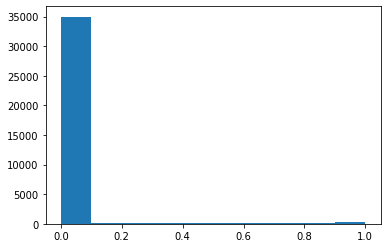

In [21]:
plt.hist(preds)

In [37]:
new_preds = (preds > 0.0092).astype('int')
pd.DataFrame({'x': new_preds})['x'].value_counts()

0    33603
1     2646
Name: x, dtype: int64

In [38]:
submit['DEBT'] = new_preds
submit['DEBT'].value_counts()

0    33603
1     2646
Name: DEBT, dtype: int64

In [39]:
submit.to_csv('submit.csv', index=False)

Должно быть приблизительно 2200 единиц

In [31]:
from sklearn.metrics import f1_score
import numpy as np

true = np.zeros((36249))
true[:2211] = 1
preds = np.zeros((36249))
pad = 1560
preds[pad:pad+2425] = 1
f1_score(true, preds)

0.28084555651423637